# Task 5 of Second Machine Learning Homework
## Overfitting and Regularization

**Dataset**: Use the following code to generate a dataset with 150 samples:

```py
np.random.seed(2)
X = np.random.uniform(-10, 10, 150)
epsilon = np.random.normal(0, 1, 150)
y = 2 * X**2 + 3 * X + 1 + epsilon
```


**Task**: Fit two models: (i) a linear regression model, and (ii) a polynomial regression model of degree 10. Compare the training and validation performance of both models. Apply L2 regularization to the polynomial model and observe the effect on overfitting.

### Polymonial regression with regularisation

In [37]:
import torch
from sklearn.model_selection import train_test_split

def train_polynomial_regression(X, y, num_epochs=1000, degree = 10, lr=0.1, rs = 0.01):
    class PolynomialRegressionModel(torch.nn.Module):
        def __init__(self, input_dim):
            super(PolynomialRegressionModel, self).__init__()
            self.poly = torch.nn.Linear(input_dim, 1)
        def forward(self, x):
            return self.poly(x)

    X_poly = torch.cat([X**i for i in range(1, degree + 1)], dim=1)

    model = PolynomialRegressionModel(degree)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        y_pred = model(X_poly)
        loss = criterion(y_pred, y)

        if rs > 0:
            reg_loss = sum(param.pow(2).sum() for param in model.parameters())
            loss += rs * reg_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print the loss every 1000 epochs
        if (epoch + 1) % 1000 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    return model


### Linear regression - tasks 2, 4

In [38]:
def train_linear_regression(X, y, num_epochs=10000, lr=0.1):
    class LinearRegressionModel(torch.nn.Module):
        def __init__(self):
            super(LinearRegressionModel, self).__init__()
            self.linear = torch.nn.Linear(1, 1)

        def forward(self, x):
            return self.linear(x)
    
    model = LinearRegressionModel()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        # Print the loss every 1000 epochs
        if (epoch + 1) % 1000 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    return model, losses



### And now do the task:
**Task**: Fit two models: (i) a linear regression model, and (ii) a polynomial regression model of degree 10. Compare the training and validation performance of both models. Apply L2 regularization to the polynomial model and observe the effect on overfitting.

**Dataset**: Use the following code to generate a dataset with 150 samples:

```py
np.random.seed(2)
X = np.random.uniform(-10, 10, 150)
epsilon = np.random.normal(0, 1, 150)
y = 2 * X**2 + 3 * X + 1 + epsilon
```


#### Step 1 - Generate data, prepare it for models and train them

In [53]:
import numpy as np

np.random.seed(2)
X = np.random.uniform(-10, 10, 150)
epsilon = np.random.normal(0, 1, 150)
y = 2 * X**2 + 3 * X + 1 + epsilon

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize
X_train_norm = (X_train - X_train.min()) / (X_train.max() - X_train.min())
y_train_norm = (y_train - y_train.min()) / (y_train.max() - y_train.min())
X_test_norm = (X_test - X_train.min()) / (X_train.max() - X_train.min())
y_test_norm = (y_test - y_train.min()) / (y_train.max() - y_train.min())

# Turn into tensors
X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32).view(-1, 1)
y_train_tensor = torch.tensor(y_train_norm, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test_norm, dtype=torch.float32).view(-1, 1)

# Train models
linear_model, _ = train_linear_regression(X_train_tensor, y_train_tensor, num_epochs=1000)
poly_model_with_reg = train_polynomial_regression(X_train_tensor, y_train_tensor, num_epochs=1000, degree=10, rs=0.05)
poly_model_no_reg = train_polynomial_regression(X_train_tensor, y_train_tensor, num_epochs=1000, degree=10, rs=0.0)


Epoch [1000/1000], Loss: 0.0725
Epoch [1000/1000], Loss: 0.0396
Epoch [1000/1000], Loss: 0.0058


#### Step 2 - Plot results of different models

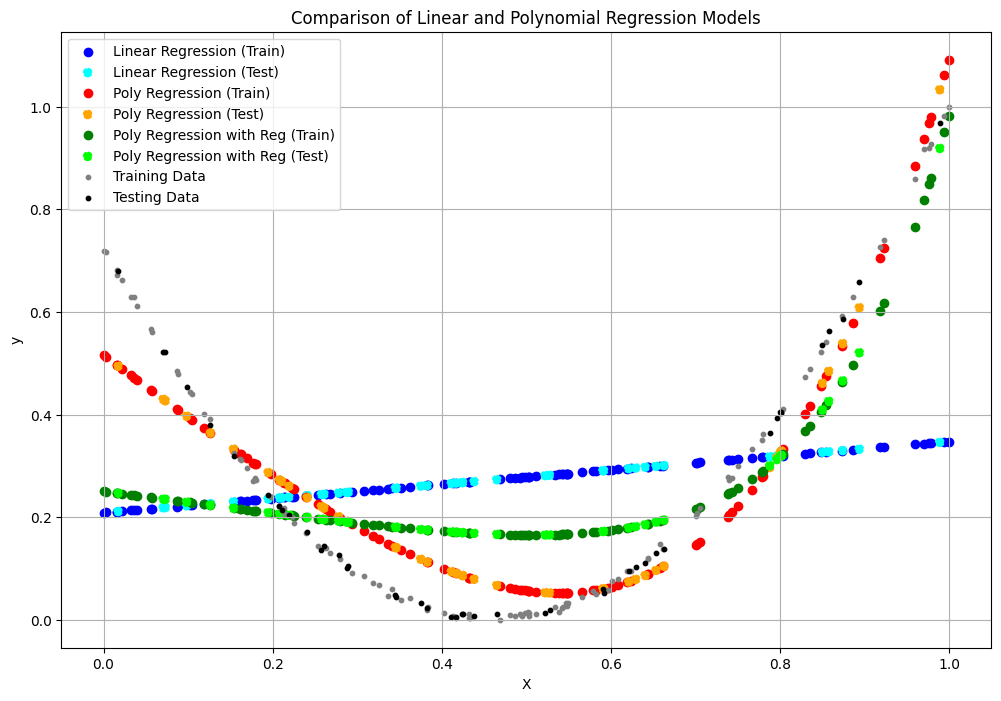

In [54]:
import matplotlib.pyplot as plt

# Predictions for plotting
X_train_poly = torch.cat([X_train_tensor**i for i in range(1, 11)], dim=1)
X_test_poly = torch.cat([X_test_tensor**i for i in range(1, 11)], dim=1)

# Linear model predictions
y_train_pred_lin = linear_model(X_train_tensor).detach().numpy()
y_test_pred_lin = linear_model(X_test_tensor).detach().numpy()

# Polynomial model predictions (with and without regularization)
y_train_pred_with_reg = poly_model_with_reg(X_train_poly).detach().numpy()
y_test_pred_with_reg = poly_model_with_reg(X_test_poly).detach().numpy()

y_train_pred_no_reg = poly_model_no_reg(X_train_poly).detach().numpy()
y_test_pred_no_reg = poly_model_no_reg(X_test_poly).detach().numpy()

# Plotting
plt.figure(figsize=(12, 8))

plt.scatter(X_train_norm, y_train_pred_lin, label='Linear Regression (Train)', color='blue')
plt.scatter(X_test_norm, y_test_pred_lin, label='Linear Regression (Test)', color='cyan', linestyle='--')
plt.scatter(X_train_norm, y_train_pred_no_reg, label='Poly Regression (Train)', color='red')
plt.scatter(X_test_norm, y_test_pred_no_reg, label='Poly Regression (Test)', color='orange', linestyle='--')
plt.scatter(X_train_norm, y_train_pred_with_reg, label='Poly Regression with Reg (Train)', color='green')
plt.scatter(X_test_norm, y_test_pred_with_reg, label='Poly Regression with Reg (Test)', color='lime', linestyle='--')
plt.scatter(X_train_norm, y_train_norm, label='Training Data', color='gray', s=10)
plt.scatter(X_test_norm, y_test_norm, label='Testing Data', color='black', s=10)

plt.xlabel('X')
plt.ylabel('y')
plt.title('Comparison of Linear and Polynomial Regression Models')
plt.legend()
plt.grid(True)
plt.show()


#### 3. Evaluate models

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Linear Model Train MSE: 0.0725
Linear Model Test MSE: 0.0507
Poly Model with Reg Train MSE: 0.0283
Poly Model with Reg Test MSE: 0.0200
Poly Model no Reg Train MSE: 0.0058
Poly Model no Reg Test MSE: 0.0051


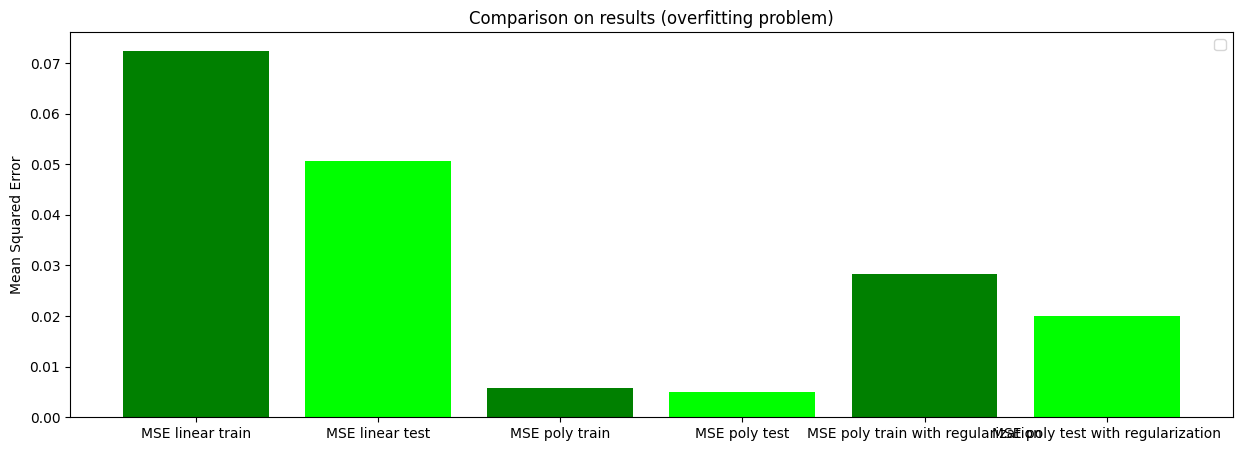

In [56]:
# Evaluate models
def evaluate_model(model, X, y, is_polynomial=False, degree=3):
    if is_polynomial:
        X_poly = torch.cat([X**i for i in range(1, degree + 1)], dim=1)
        predictions = model(X_poly)
    else:
        predictions = model(X)
    mse = torch.mean((predictions - y) ** 2)
    return mse.item()

linear_train_mse = evaluate_model(linear_model, X_train_tensor, y_train_tensor, is_polynomial=False)
linear_test_mse = evaluate_model(linear_model, X_test_tensor, y_test_tensor, is_polynomial=False)

poly_train_mse_with_reg = evaluate_model(poly_model_with_reg, X_train_tensor, y_train_tensor, is_polynomial=True, degree=10)
poly_test_mse_with_reg = evaluate_model(poly_model_with_reg, X_test_tensor, y_test_tensor, is_polynomial=True, degree=10)

poly_train_mse_no_reg = evaluate_model(poly_model_no_reg, X_train_tensor, y_train_tensor, is_polynomial=True, degree=10)
poly_test_mse_no_reg = evaluate_model(poly_model_no_reg, X_test_tensor, y_test_tensor, is_polynomial=True, degree=10)

# Print MSE values
print("Linear Model Train MSE:", f"{linear_train_mse:.4f}")
print("Linear Model Test MSE:", f"{linear_test_mse:.4f}")
print("Poly Model with Reg Train MSE:", f"{poly_train_mse_with_reg:.4f}")
print("Poly Model with Reg Test MSE:", f"{poly_test_mse_with_reg:.4f}")
print("Poly Model no Reg Train MSE:", f"{poly_train_mse_no_reg:.4f}")
print("Poly Model no Reg Test MSE:", f"{poly_test_mse_no_reg:.4f}")


plt.figure(figsize=(15, 5))
plt.bar("MSE linear train", linear_train_mse, color='green')
plt.bar("MSE linear test", linear_test_mse, color='lime')
plt.bar("MSE poly train", poly_train_mse_no_reg, color='green')
plt.bar("MSE poly test", poly_test_mse_no_reg, color='lime')
plt.bar("MSE poly train with regularization", poly_train_mse_with_reg , color='green')
plt.bar("MSE poly test with regularization", poly_test_mse_with_reg, color='lime')

plt.ylabel('Mean Squared Error')
plt.title('Comparison on results (overfitting problem)')
plt.legend()
plt.show()



## Conclusions

Regularization is a good tool to help us with overfitting. In this example using that tool
is not necessary. Obviously linear model is not able to capture the curve accurately
(just like in task 4).